### Compute the RAScore of the molecules

In [1]:
from RAscore import RAscore_XGB, RAscore_NN

2022-01-22 20:26:44.694302: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
rascorer = RAscore_NN.RAScorerNN()

2022-01-22 20:26:47.340904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-22 20:26:47.452834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 20:26:47.454022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M2200 computeCapability: 5.2
coreClock: 1.036GHz coreCount: 8 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 82.08GiB/s
2022-01-22 20:26:47.454143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-22 20:26:47.471179: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-22 20:26:47.471318: I tensorflow/stream_executor/platform/default

In [3]:
mol = 'COCOCO'
rascorer.predict(mol)

2022-01-22 16:16:51.094222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 16:16:51.113407: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz


0.99948967

In [3]:
# open the smiles lists
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from rdkit import Chem
# from gym_PGFS.scorers.scorer import GuacamolMGenFailScorer
# from gym_PGFS.valuation.plot_utils import plot_medians, process_output_into_dataframe

In [4]:
run_dirs = {'./data/run_B': 'CHEMBL3888429', 
            './data/run_A': 'CHEMBL1909140', 
            './data/run_C': 'CHEMBL1909203'}
dsets = ['CHEMBL3888429', 'CHEMBL1909140', 'CHEMBL1909203']

lstm_out = {}

for name in dsets:
    lstm_out[name] = pd.read_csv(f"./data/lstm_hc/{name}_outcome.csv")
    
# now do the same for an output of pgfs


pgfs_out = {}

for location, name in run_dirs.items():
    df = pd.read_csv(f"{location}/smiles_collected.csv")
    print(len(df))
    print(df['step'].unique()) 
    print("Picking 5")
    df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])
    pgfs_out[name] = df

    

37800
[0 1 2 3 4 5]
Picking 5
91800
[0 1 2 3 4 5]
Picking 5
91800
[0 1 2 3 4 5]
Picking 5


/tmp/ipykernel_6988/3196589372.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df[df['step']==5].reset_index().drop('index', 1)[['smiles', 'epoch', 'type', 'value']].sort_values(by=['type'], ascending=False).sort_values(by=['epoch'])


In [5]:
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]

    rascore_lstm = lstm.smiles.apply(rascorer.predict)

    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]

    rascore_pgfs = pgfs.smiles.apply(rascorer.predict)

    # now make a boxplot
    lstms[dataset_name] = rascore_lstm.to_numpy()
    pgfss[dataset_name] = rascore_pgfs.to_numpy()

2022-01-22 20:26:51.236048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 20:26:51.255842: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz


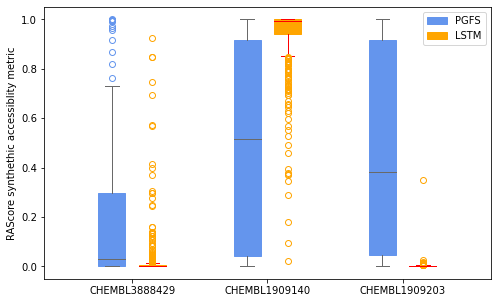

In [6]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
plt.ylabel(f"RAScore synthethic accessiblity metric")
# plt.xlabel("")

rng = np.arange(len(pgfs_out.keys()))
c, c_highlight = 'cornflowerblue', 'dimgrey'
pgfs_boxes = ax.boxplot(pgfss.values(), patch_artist=True, positions=rng-0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))
c, c_highlight = 'orange', 'red'
lstm_boxes = ax.boxplot(lstms.values(), patch_artist=True, positions=rng+0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))

ax.legend([pgfs_boxes["boxes"][0], lstm_boxes["boxes"][0]],
          ['PGFS', 'LSTM'],
          loc='upper right')

plt.xticks(rng, pgfss.keys())
plt.show()

C#CCOOOON(c1ccc(Cc2cnc(C(=O)c3ccc(C#N)cc3)cn2)cn1)C(C(=O)CC(=O)Nc1ccc(S(=O)(=O)C(F)(F)F)cc1)C(C)(C)F


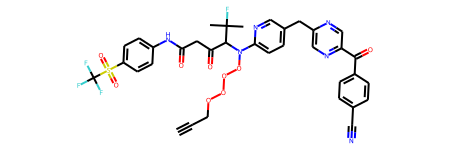

C#CCOOOOOOON(c1ccc(C(=O)c2ccc(S(=O)(=O)C(F)(F)F)cc2)cn1)C(C(=O)CCC(=O)Nc1ccc(C#N)cc1)c1ccc(C#N)cc1


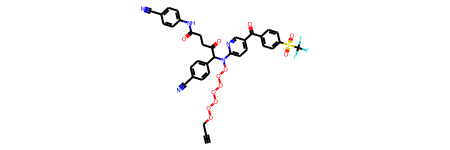

C#CCN(c1ccc(COc2ccc(C(=O)c3ccc(S(=O)(=O)C(F)(F)F)cc3)cc2C)cn1)C(C(=O)N(N)c1ccc(C#N)cc1)C(C)(C#N)C=CI


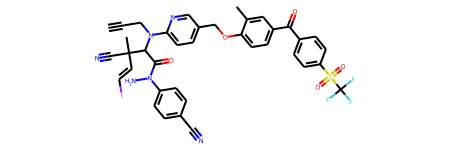

C#CCOOOON(c1ccc(C(=O)c2ccc(S(=O)(=O)C(F)(F)F)cc2)cn1)C(C(=O)CCCCCCCC(=O)Nc1ccc(C#N)cc1)c1cnn(CC#N)c1


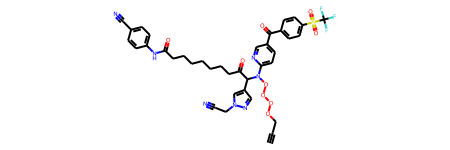

C#CCOOOOONN(c1ccc(C(=O)c2ccc(S(=O)(=O)C(F)(F)F)cc2)cn1)C(C(=O)CCC(=O)Nc1ccc(C#N)cc1)c1cnn(CC#N)n1


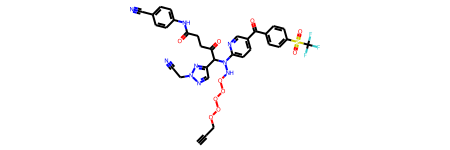

C#CCOOOOON(c1ccc(Cc2ccc(C(=O)c3ccc(C#N)cc3)nc2)cn1)C(C(=O)CC(=O)Nc1ccc(S(=O)(=O)C(F)(F)F)cc1)C(C)C


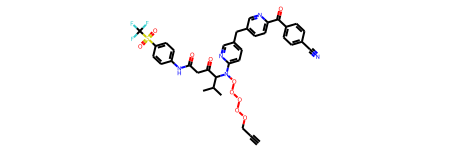

C#CCOOOOON(c1ccc(C(=O)c2ccc(C#N)cc2)cn1)C(C(=O)CCC=CCCCC(=O)Nc1ccc(S(=O)(=O)C(F)(F)F)cc1)N(O)O


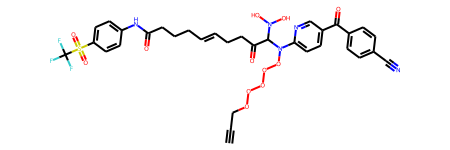

C#CCOOOOON(c1ccc(C(=O)c2ccc(S(=O)(=O)C(F)(F)F)cc2)cn1)C(C(=O)CCCCC(=O)Nc1ccc(C#N)cc1)c1cnc(C#N)cn1


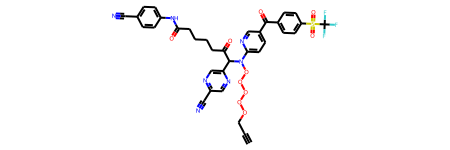

C#CCON(c1ccc(Cc2ncc(C(=O)c3ccc(C#N)cc3C)nn2)cn1)C(C(=O)CC(=O)Nc1ccc(S(=O)(=O)C(F)(F)F)cc1)C(C)(I)C#N


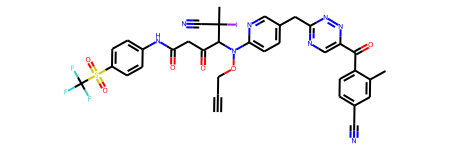

C#CCOOOOOOON(c1ccc(C(=O)c2ccc(S(=O)(=O)C(F)(F)F)cc2)cn1)C(C(=O)CCCCC(=O)Nc1ccc(C#N)cc1)c1ccc(C#N)cc1


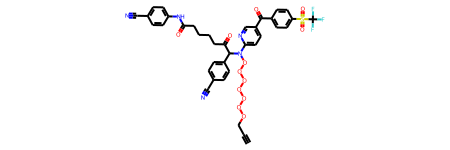

In [28]:
# visualize some molecules
lstm = lstm_out['CHEMBL3888429']
last_lstm = lstm.epoch.max()
lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)].smiles.sample(10)
for smi in lstm.tolist():
    print(smi)
    display(Chem.MolFromSmiles(smi))

CN(C)S(=O)(=O)CC(NC(=O)CC1C=C(C(COC(=O)c2cncc(C(F)F)c2)NS(=O)(=O)Cc2cccc([N+](=O)[O-])c2)CC2N(Cc3ccc(S(N)(=O)=O)cc3)N=NC12C)C(F)(F)F


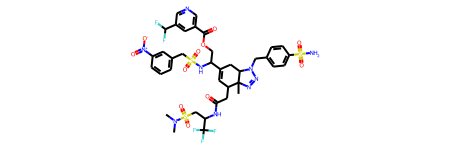

CC(C)=C(C(NN)c1nc2c([N+](=O)[O-])cc(Br)cc2c(=O)n1Cc1ccc(C(F)(F)F)nc1)C1C(C)(C)C1(C(=O)NN)C(=O)C(O)C1CCCC1


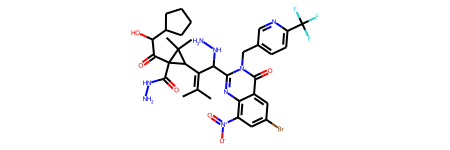

CNS(=O)(=O)c1cc2sc(CC(F)C(=O)C(NS(=O)(=O)NC(C)C)C(Br)C(=O)c3ccc(NS(C)(=O)=O)nc3)nc2cc1C(=O)Cc1ccc(C(F)(F)F)nc1


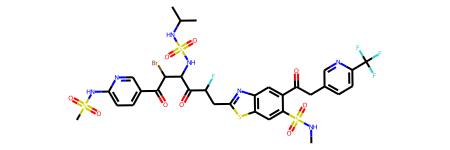

CNS(=O)(=O)c1cccc(C(C)N(C2CC(C#N)(c3ccc(F)cc3)C2)C(c2ccc(S(=O)(=O)NCCBr)s2)c2cc(COC(=O)CNN)cnc2C(F)(F)F)c1


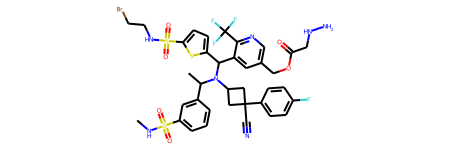

COc1cc2c(c(C(=O)NCC(=O)C(O[Si](C)(C)C(C)(C)C)C(C(=O)C=CC(=O)c3ccc(OC(F)(F)F)cn3)c3cnn(CCC(F)(F)F)c3)c1)OCC2


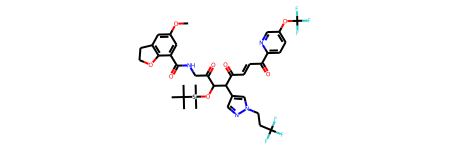

CCCCc1cc2c(n1[C@@H](COC(=O)CCSc1cc(C)ccc1NC(=O)Cn1nc(C)c([N+](=O)[O-])c1C)C1CC3CCN(C(=O)C(F)(F)F)CC34C(C1)N=NN4Cc1nnc(C)o1)CCCC2


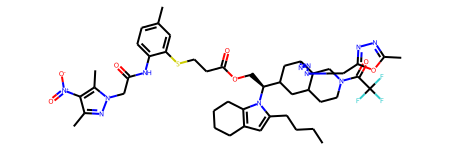

CC(Cc1cnc(C(F)(F)F)nc1)c1nc(-c2cc(C#Cc3cnc(OC(F)(F)F)cn3)c(Oc3ccc(OC(F)(F)F)nc3)c([N+](=O)[O-])c2C(=O)c2ccc(OC(F)(F)F)nc2)no1


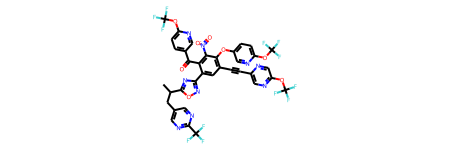

CC(C=CCCc1ccc(C(=O)Nc2ncc(OC(F)(F)F)cc2C#Cc2cnc(OC(F)(F)F)cn2)cc1)c1nc2c(C(C)(C)C)cc(C#Cc3cnc(OC(F)(F)F)cn3)cc2o1


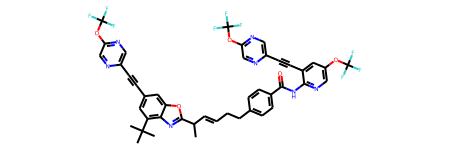

CC(O)CC(=O)C1(Cl)CC1C(c1cncc(C(F)(F)F)c1)N(C(=O)c1ccnc(OC(F)F)c1)c1ccc([S+](C)[O-])c(F)c1


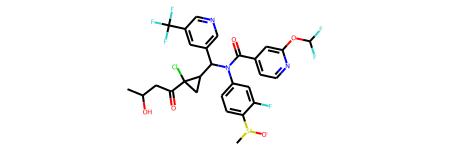

CC(C)(NC(CNNS(=O)(=O)Cc1ccc(-c2ccc3c(c2)OC(F)(F)O3)c(F)c1)c1cc(CCl)cnc1C(F)(F)F)c1nc(C(=O)c2cnncc2C(F)(F)F)cc(C(F)(F)F)n1


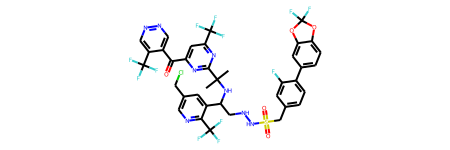

In [29]:
# visualize some molecules
pgfs = pgfs_out['CHEMBL3888429']
last_pgfs = pgfs.epoch.max()
pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)].smiles.sample(10)
for smi in pgfs.tolist():
    print(smi)
    display(Chem.MolFromSmiles(smi))

<b>Sampling some molecules from LSTM and PGFS on CHEMBL1909140:</b>
<b>LSTM:</b>
CN(C)CCCOCCOCCCOCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CCCN1c2ccc(Cl)cc2Sc2cc3cc(I)c4cc(Cl)ccc4c3cc21
0.9934893


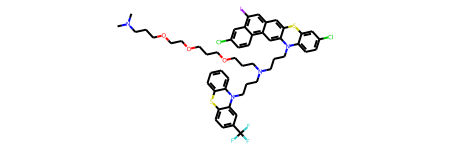

CN(C)CCCOCCOCCCOCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CCCN1c2cc(B(O)O)ccc2Sc2c1cc(I)c1cc(Cl)ccc21
0.9992789


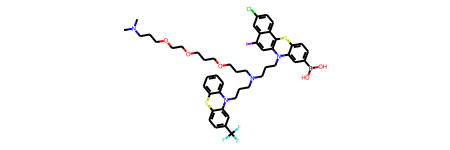

CN(C)CCCOCCOCCOCCCOCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CN1c2ccc(B(O)O)cc2Sc2c1cc(I)c1ccc(Cl)cc21
0.89094925


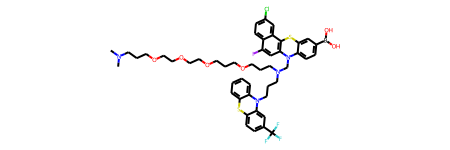

CN(C)CCCOCCOCCOCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CN1c2ccccc2Sc2c1cc(I)c1cc(Cl)ccc21
0.9644261


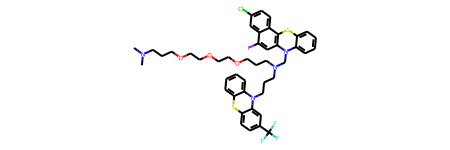

CN(C)CCCOCCOCCOCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CN1c2cc3ccccc3cc2Sc2cc3cc(I)c4ccc(Cl)cc4c3cc21
0.9748392


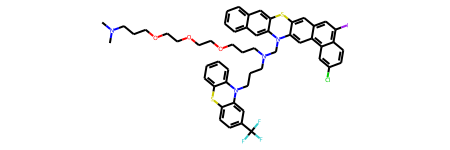

CN(C)CCCOCCOCCCOCCCCN(CCCN1c2ccccc2Sc2ccc(B(O)O)cc21)CN1c2cc(C(F)(F)F)ccc2Sc2c1cc(I)c1ccc(Cl)cc21
0.9520257


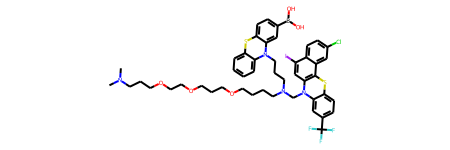

CN(C)CCCOCCOCCCOCCCCN(CCCN1c2ccccc2Sc2cc(Cl)ccc21)CCCN1c2cc(C(F)(F)F)ccc2Sc2c1cc(I)c1ccc(B(O)O)cc21
0.99925053


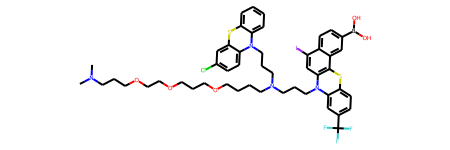

CN(C)CCCOCCOCCCOCCCCOCCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CCCN1c2ccc(Cl)cc2Sc2c1cc(I)c1cc(Cl)ccc21
0.9981621


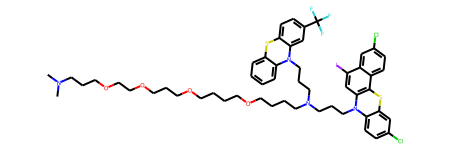

CN(C)CCCOCCOCCCOCCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CCCN1c2ccccc2Sc2c1ccc1c2cc(I)c2ccc(Cl)cc21
0.999713


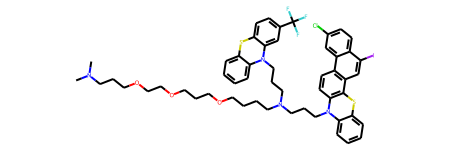

CN(C)CCCOCCOCCOCCCOCCCCN(CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21)CN1c2ccccc2Sc2c1cc(I)c1ccc(Cl)cc21
0.9941168


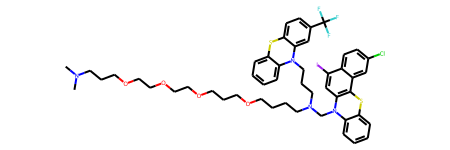

<b>PGFS:</b>
CCN1CCN(CCC(=O)OCC2C(Cn3c4cc(C)c3c3c4C4CC3C(N3N=NC5(c6ccccc6F)CNCC35)C4)N=NN2CCN2CCCC2)CC1
1.0878513e-06


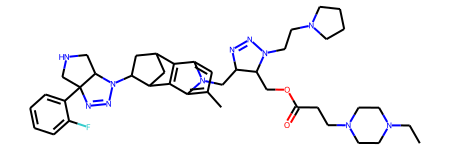

COc1ccc2ncn(CCN3CC4C(C3)C3CCC4C4N(CCCN5CCCC5)N=NC34C(C)c3nc4c(Br)cc(CCCN5CCN(C)CC5)c(C(=O)O)c4o3)c(=O)c2c1Br
0.00044879317


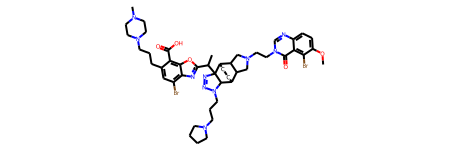

O=C(C(Cl)Cl)C1CSc2ccccc2N(C(=O)COCCN2CCCCC2)C1=O
0.16993666


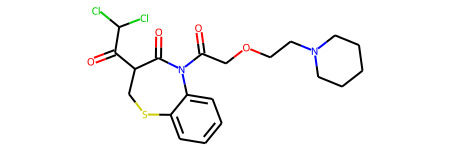

CN1CCN(CCCS(=O)(=O)NCCCCN2CCN(CCOC(=O)C(C)(Cl)Br)CC2)CC1
0.99995625


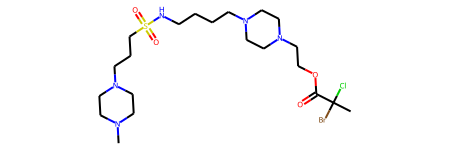

C[C@@H](OCC(CCNC(=O)C(CCN1CCOCC1)n1c(C2CC2)ccc1C1CC1)N1CCN(C)CC1)c1nc2cc3c(cc2s1)OCCCO3
0.108432055


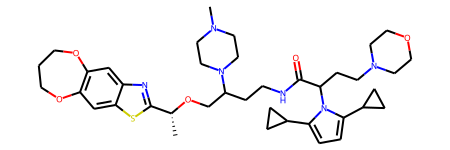

CNC(OCCCCCN1CCNCC1)C(=O)C#CCn1c(CN2CCCNCC2)nc2c(F)ccc(F)c2c1=O
0.3523032


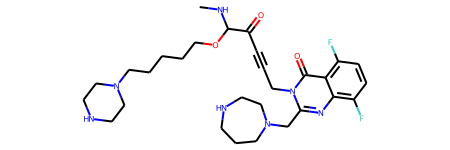

CN1CCN(c2ncc(C(=O)C3(O)CN(CCCN(C)Cc4nc5cc6c(cc5s4)OCCCO6)CCO3)s2)CC1
0.9999913


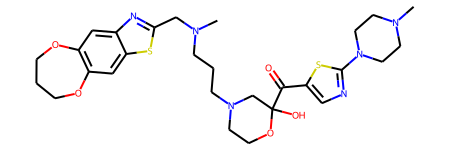

CN1CCN(CCCOC(CN2CCOCC2)C(=O)CNNS(=O)(=O)CCSc2ccccc2)CC1
0.80739796


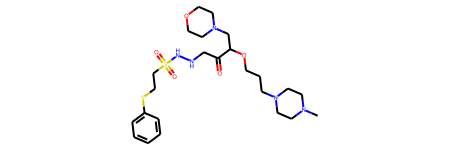

Cc1c(C(=O)C(C)(C)CN2CCN(C)CC2)c2c3c(c1n2CC(=O)Cl)C1CC3C2N(CC3CCNC3)N=NC12C(=O)COCCN1CCCCC1
4.6801915e-07


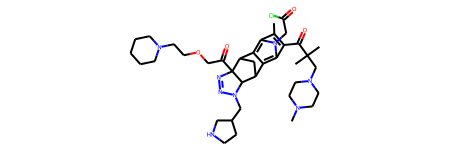

C=C(CN1CCNC(C(=O)c2cncc(N3CC(C)C3)c2)CC1)c1cc(Br)c(C(=O)OC(C)CN2CCSC(C)(C)C2)c2oc([C@@H](C)OCCCN3CCN(C)CC3)nc12
0.027234703


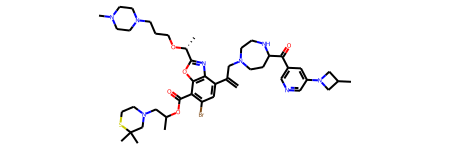

In [7]:
# visualize some molecules
current_set = 'CHEMBL1909140'
print(f'<b>Sampling some molecules from LSTM and PGFS on {current_set}:</b>')
print('<b>LSTM:</b>')
lstm = lstm_out[current_set]
last_lstm = lstm.epoch.max()
lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)].smiles.sample(10)
for smi in lstm.tolist():
    print(smi)
    print(rascorer.predict(smi))
    display(Chem.MolFromSmiles(smi))
# visualize some molecules
print('<b>PGFS:</b>')
pgfs = pgfs_out[current_set]
last_pgfs = pgfs.epoch.max()
pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)].smiles.sample(10)
for smi in pgfs.tolist():
    print(smi)
    print(rascorer.predict(smi))
    display(Chem.MolFromSmiles(smi))

## Let's try plotting the DCS comparison plot from the other notebook, but only using the scores from the top 50% best RAScoring molecules:

In [8]:
lstms = {}
pgfss = {}
for dataset_name in pgfs_out.keys():
    # get the lstm and pgfs datasets ( only dcs scores of the last epoch )
    lstm = lstm_out[dataset_name]
    last_lstm = lstm.epoch.max()
    lstm = lstm[(lstm['type']=='DCS_MODE')&(lstm['epoch']==last_lstm)]

    rascore_lstm = lstm.smiles.apply(rascorer.predict)
    # now compute the median score, and leave only the compounds, that are above that
    lstm_median_rascore = rascore_lstm.quantile(0.8)
    lstm = lstm[rascore_lstm>lstm_median_rascore]
    
    pgfs = pgfs_out[dataset_name]
    last_pgfs = pgfs.epoch.max()
    pgfs = pgfs[(pgfs['type']=='DCS_MODE')&(pgfs['epoch']==last_pgfs)]
    
    rascore_pgfs = pgfs.smiles.apply(rascorer.predict)
    # now compute the median score, and leave only the compounds, that are above that
    pgfs_median_rascore = rascore_pgfs.quantile(0.8)
    pgfs = pgfs[rascore_pgfs>pgfs_median_rascore]
    
    # now make a boxplot
    lstms[dataset_name] = lstm.value.to_numpy()
    pgfss[dataset_name] = pgfs.value.to_numpy()
    


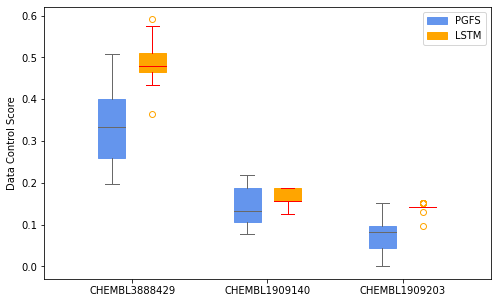

In [9]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
plt.ylabel(f"Data Control Score")
# plt.xlabel("")

rng = np.arange(len(pgfs_out.keys()))
c, c_highlight = 'cornflowerblue', 'dimgrey'
pgfs_boxes = ax.boxplot(pgfss.values(), patch_artist=True, positions=rng-0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))
c, c_highlight = 'orange', 'red'
lstm_boxes = ax.boxplot(lstms.values(), patch_artist=True, positions=rng+0.15, widths=0.2,
                            boxprops=dict(facecolor=c, color=c),
                            capprops=dict(color=c_highlight),
                            whiskerprops=dict(color=c_highlight),
                            flierprops=dict(color=c, markeredgecolor=c),
                            medianprops=dict(color=c_highlight))

ax.legend([pgfs_boxes["boxes"][0], lstm_boxes["boxes"][0]],
          ['PGFS', 'LSTM'],
          loc='upper right')

plt.xticks(rng, pgfss.keys())
plt.show()